## B-Spline basis functions

In [1]:
import ipympl
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import ConvexHull

_ = plt.ioff()

In [2]:
def N_i_k(i:int, k:int, t:float, T:np.ndarray):
    """
    Calculate B-spline basis functions.
    
    Input:
    ------
    i: i should be an integer in between 0 and n where n >= k - 1.
    k: order of the B-splines (the degree is k-1). It should be an integer
    t: value of the parameter at which to evaluate.
    T: the complete knot vector. Length will be assumed as n+k+1.

    Output:
    -------
    The value of N_{i,k}(t).
    """
    if k < 1:
        raise AssertionError(f'The order k should be greater than 1.')
    # Assuming len(T) = n+k+1
    n = len(T) - k - 1
    if (n < 0) or n < (k - 1):
        raise AssertionError('The length of knot vector should be n+k+1 where n >= (k-1)')
    if (i < 0) or (i > n):
        raise AssertionError(f'In this case, n={n}, and i={i} is not in [0,n].')

    t = np.asarray_chkfinite(t)
    T = np.asarray_chkfinite(T)
    if k == 1:
        return np.where(np.logical_and(T[i] <= t, t < T[i+1]),
                        np.ones_like(t),
                        np.zeros_like(t))
    else:
        if T[i+k-1] == T[i]:
            first_term = 0.0
        else:
            N_i_km1 = N_i_k(i, k-1, t, T)
            first_term = (t - T[i])/(T[i+k-1] - T[i]) * N_i_km1
        if T[i+k] == T[i+1]:
            second_term = 0.0
        else:
            N_ip1_km1 = N_i_k(i+1, k-1, t, T)
            second_term = (T[i+k] - t)/(T[i+k] - T[i+1]) * N_ip1_km1
        return first_term + second_term

In [3]:
plt.style.use('ggplot')
plt.rcParams['text.usetex'] = True

def plot_all_bspline_basis_funcs(k, T, title=None, numpoints=101, fontsize=16):
    """
    Plot all the B-spline basis functions for a given knot-vector T and order k.
    """
    assert k >= 1
    n = len(T) - k - 1
    assert n > 0
    assert n >= (k - 1)
    T = np.asarray_chkfinite(T)
    t = np.linspace(T.min(), T.max(), numpoints, endpoint=False)
    plt.rcParams['font.size'] = fontsize
    fig, ax = plt.subplots()
    ax.set_xlabel(r'$t$')
    ax.set_ylabel(r'$N_{i,k}(t)$')
    for i in range(n+1):
        Nik = N_i_k(i, k, t, T)
        ax.plot(t, Nik, label=f'$N_{{{i},{k}}}(t)$')
    ax.legend()
    if title:
        ax.set_title(title)
    fig.set_tight_layout(True)
    return fig

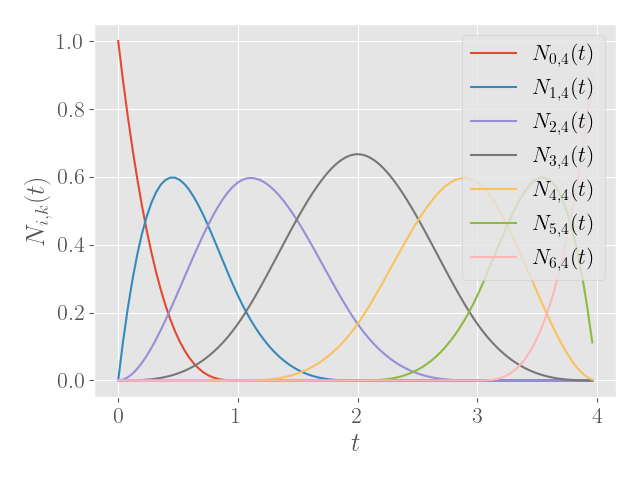

In [4]:
T = np.array([0,0,0,0,1,2,3,4,4,4,4])
fig1 = plot_all_bspline_basis_funcs(4, T)
display(fig1.canvas)

## B-Spline Curves

In [5]:
def b_spline_curve(control_points, k, T, numpoints=100):
    """
    Calculate points on a B-spline curve.

    Input:
    ------
    control_points: numpy.ndarray of shape (n, 2), where n >= (k - 1).
    k: order of the curve. k < (n + 1).
    T: the knot vector. len(T) = n+k+1.
    numpoints: the number of points of the curve to be calculated.

    Output:
    -------
    P: numpy.ndarray of shape (numpoints, 2).
    """
    assert k > 1
    T = np.asarray_chkfinite(T)
    n = len(T) - k - 1
    assert n > 0
    assert n >= (k - 1)
    assert control_points.shape[1] == 2

    t = np.linspace(T[k-1], T[n+1], numpoints, endpoint=False)
    P = np.zeros((numpoints, 2))
    for i in range(n+1):
        P[:,0] += control_points[i, 0] * N_i_k(i, k, t, T)
        P[:,1] += control_points[i, 1] * N_i_k(i, k, t, T)
    
    return P

In [12]:
def plot_b_spline_curve(control_points, k, T, numpoints=100, title=None, plot_control_poly=False, plot_convex_hull=False, fontsize=16):
    """
    Point a B-spline curve.

    Input:
    ------
    control_points: numpy.ndarray of shape (n, 2), where n >= (k - 1).
    k: order of the curve. k < (n + 1).
    T: the knot vector. len(T) = n+k+1.
    numpoints: the number of points of the curve to be calculated.
    title: title of the plot
    fontsize: font size of the plot labels, legend etc.
    plot_control_poly: flag to determine if the control polygon should be plotted.
    plot_convex_hull: flag to determine if the convex hull should be plotted.

    Output:
    -------
    fig: a Matplotlib figure.
    """
    curve_points = b_spline_curve(control_points, k, T, numpoints)

    plt.rcParams['text.usetex'] = True
    plt.rcParams['font.size'] = fontsize
    fig, ax = plt.subplots()
    fig.set_tight_layout(True)
    ax.set_aspect('equal')
    if title:
        ax.set_title(title)
    ax.plot(curve_points[:,0], curve_points[:,1], label='B-spline curve')
    if plot_control_poly:
        ax.plot(control_points[:,0], control_points[:,1], marker='o', ls='--', color='k', label='Control Polygon')
    if plot_convex_hull:
        hull = ConvexHull(control_points)
        hull_verts = np.append(hull.vertices, hull.vertices[0])
        ax.plot(control_points[hull_verts,0], control_points[hull_verts,1], ls='dotted', color='g', label='Convex hull')
    if plot_control_poly or plot_convex_hull:
        ax.legend()
    
    return fig

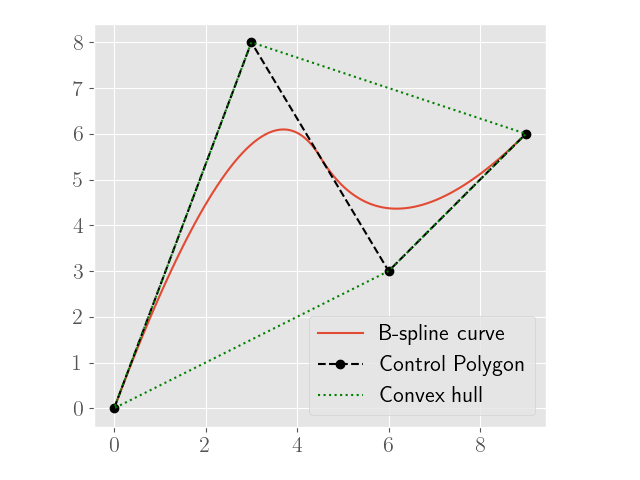

In [13]:
P = np.array([[0,0], [3, 8], [6,3], [9, 6]])
#T = np.array([0, 1, 2, 3, 4, 5, 6])
T = np.array([0, 0, 0, 1, 2, 2, 2])
k = 3
fig2 = plot_b_spline_curve(P, k, T, plot_control_poly=True, plot_convex_hull=True)
display(fig2.canvas)